In [1]:
#llamamos las librerias que utilizaremos 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Vamos a tomar el URL del archivo en formato (raw)
url='https://raw.githubusercontent.com/Abel-Lemus/Computacional-1-/main/Evaluacion%201/Datos%20de%20evaluacion%201.txt'

#Usamos pandas para leerlo tomando en consideración que tenemos que ignorar
#las primeras 152 lineas y que los datos están separados por espacios.
df = pd.read_csv(url, error_bad_lines= False, skiprows=151, delimiter=' ',na_values=-999.99)

#Creamos una columna con la fecha 
df['date']=pd.to_datetime(df[['year', 'month', 'day']])

#Eliminamos las columnas de fecha que ya no usaremos

del df['month']
del df['day']
del df['hour']
del df['minute']
del df['second']
del df['time_decimal']

#Como la columna de fehca aparece al final, cambiamos el orden de las columnas para que la ultima sea la primera.
#esto no cambia nada a terminos practicos, solo es para ver la fecha al inicio.
#cols  = df.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#df = df[cols]
df = df.set_index(['date'])
df.head()

,site_code,year,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
date,,,,,,,,,,,
1973-01-01,MLO,1973,NaN,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
1973-01-02,MLO,1973,NaN,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
1973-01-03,MLO,1973,NaN,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
1973-01-04,MLO,1973,NaN,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
1973-01-05,MLO,1973,NaN,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..


In [3]:
#creamos otro dataframe que contenga los datos que van de 1975 a 2019
df1=df[(df.year >= 1975) & (df.year<= 2019)]
df1.head()

,site_code,year,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
date,,,,,,,,,,,
1975-01-01,MLO,1975,330.39,0.45,12,19.536,-155.576,3437.0,3397.0,40.0,...
1975-01-02,MLO,1975,330.17,0.17,15,19.536,-155.576,3437.0,3397.0,40.0,...
1975-01-03,MLO,1975,330.65,0.16,9,19.536,-155.576,3437.0,3397.0,40.0,...
1975-01-04,MLO,1975,330.77,0.11,10,19.536,-155.576,3437.0,3397.0,40.0,...
1975-01-05,MLO,1975,330.66,0.20,7,19.536,-155.576,3437.0,3397.0,40.0,...


In [4]:
df2=df1[('value')]
df2=df2.fillna(method='ffill')
df2.head()

date
1975-01-01    330.39
1975-01-02    330.17
1975-01-03    330.65
1975-01-04    330.77
1975-01-05    330.66
Name: value, dtype: float64

In [6]:
#Parte 2 
#Define una función para probar estacionaridad utilizando la Prueba Avanzada de Dickey-Fuller: test_stationarity(df_ts)

def test_stationarity(df_ts):

  #Datos para las graficas, mostrando un año 
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 


  # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Vamos a graficar la parte estadistica 
  #Incluyendo cada uno de los parametros a ver con su respectivo distintivo
    plt.plot(df_ts, color='lime',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='green', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desvación Estándar')

  #Cuadros para la grafica 
    plt.grid()
    plt.show()

  #Vamos a comenzar realizando la prueba de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

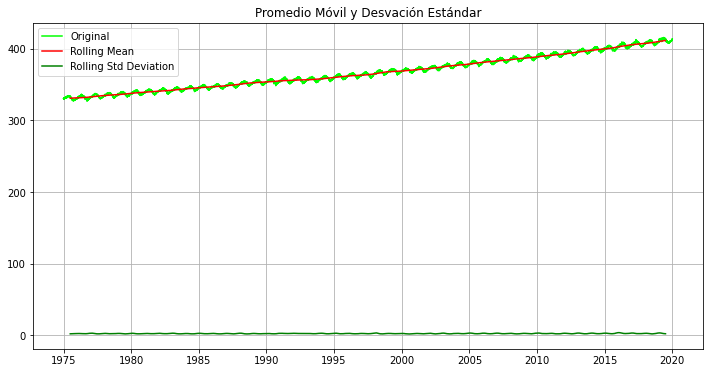

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -0.933691
p-value                            0.776675
#Lags Used                        43.000000
Number of Observations Used    16392.000000
Critical Value (1%)               -3.430749
Critical Value (5%)               -2.861716
Critical Value (10%)              -2.566864
dtype: float64


In [7]:
test_stationarity(df2)

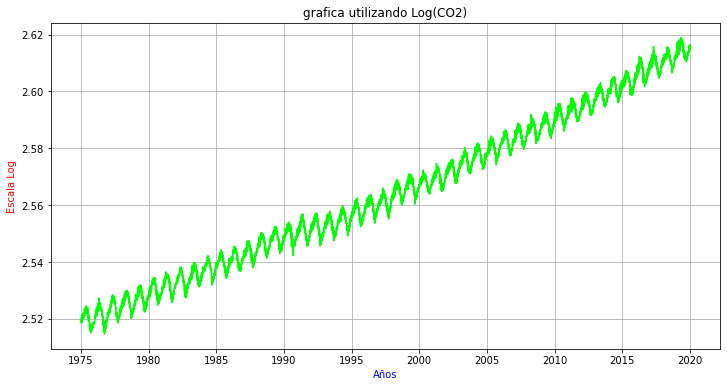

In [10]:
#Ahora vamos a hacer una serie de tiempo estacionaria, cambia de escala a Log(CO2), y gráfica la nueva función.

ts_test_log = np.log10(df2)
plt.plot(ts_test_log, color='lime')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='r')
plt.title('grafica utilizando Log(CO2)')
plt.grid()
plt.show();

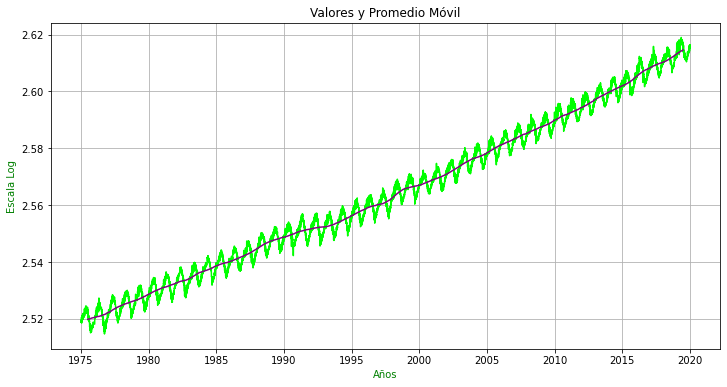

In [12]:
#Haz una descomposición estacional de la serie 'ts_test_log', usando interpolación, y promedio móvil de 365 días. Produce las gráficas de las series que la componen. 
#Comenta la serie de tendencia (aumento de CO2), estacionalidad (dependencia de las estaciones del año) y residuo (el resto).  


moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log, color="lime")
plt.plot(moving_avg, color = 'purple')
plt.xlabel('Años',color='g')
plt.ylabel('Escala Log',color='g')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [13]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
dfe = ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

date
1975-07-02    0.002623
1975-07-03    0.002352
1975-07-04    0.002562
1975-07-05    0.002239
1975-07-06    0.002217
Name: value, dtype: float64

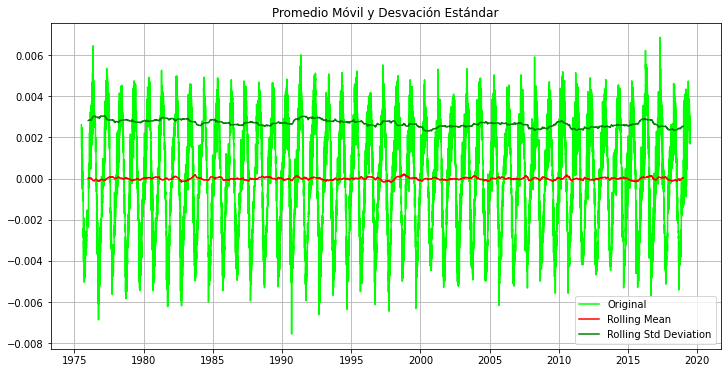

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.519801e+01
p-value                        5.883355e-28
#Lags Used                     4.300000e+01
Number of Observations Used    1.602800e+04
Critical Value (1%)           -3.430758e+00
Critical Value (5%)           -2.861720e+00
Critical Value (10%)          -2.566866e+00
dtype: float64


In [14]:
test_stationarity(ts_test_log_moving_ave_diff)

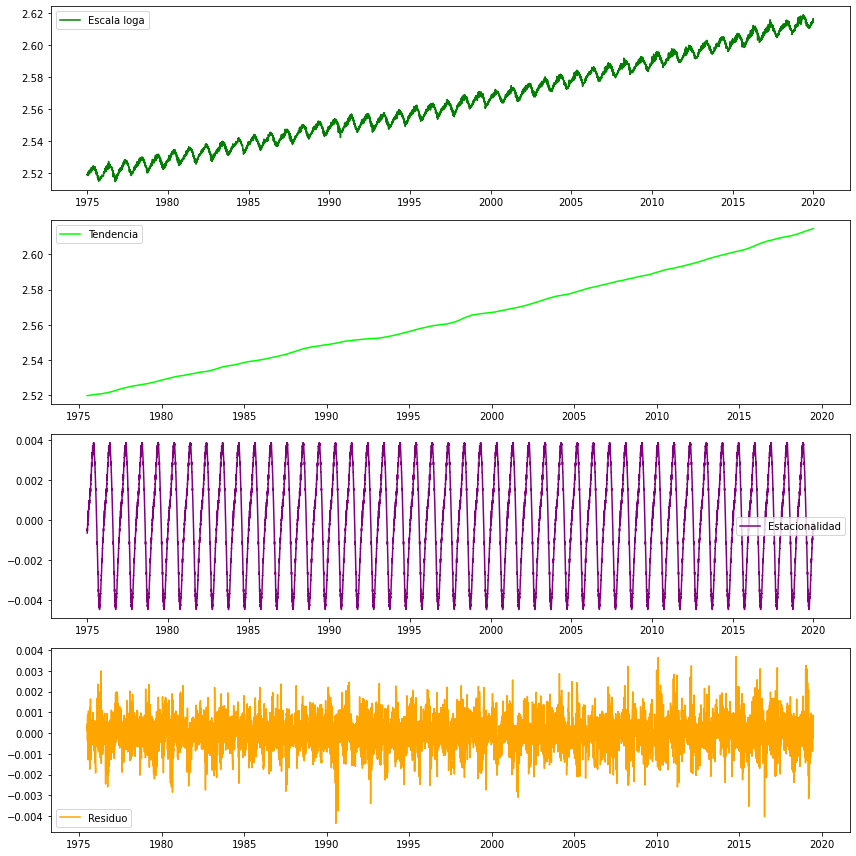

In [19]:
# Por medio del metodo de descomposicion y con ayuda de la biblioteca de python usaremos statsmodels.tsa

descomposicion_estacional = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# vamos a utilizar 3 componentes las cuales seran: Tendencia, estacionalidad y residuo

Tendencia = descomposicion_estacional.trend
Estacionalidad = descomposicion_estacional.seasonal
Residuo = descomposicion_estacional.resid

# Exmpezaremos graficando la grafica de los componentes 
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Escala loga', color='g')
plt.legend(loc='best')

#La de tendencia 
plt.subplot(412)
plt.plot(Tendencia, label='Tendencia', color='lime')
plt.legend(loc='best')

# La grafica de estacionalidad 
plt.subplot(413)
plt.plot(Estacionalidad, label='Estacionalidad', color='purple')
plt.legend(loc='best')

#La de residuo 
plt.subplot(414)
plt.plot(Residuo, label='Residuo', color='orange')
plt.legend(loc='best')

# Colocamos la siguiente linea de codigo para hacer mas estrellos los espacios de cada grafica 
# Esto para podere obtimizar de la mejor manera el espacio 
plt.tight_layout();

Por medio de estas graficas podemos observar una creciente en el gas de ( CO2 )

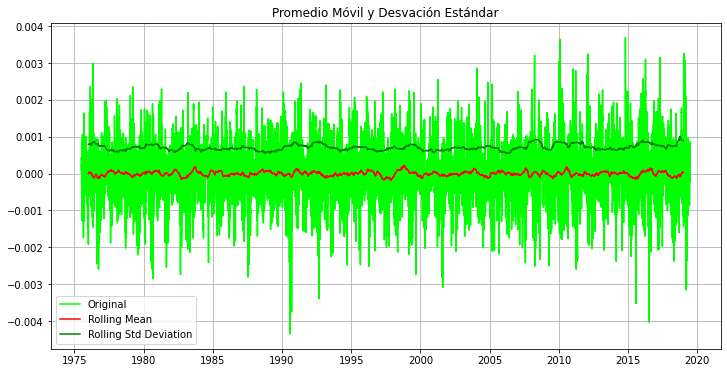

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -19.848350
p-value                            0.000000
#Lags Used                        22.000000
Number of Observations Used    16049.000000
Critical Value (1%)               -3.430758
Critical Value (5%)               -2.861720
Critical Value (10%)              -2.566866
dtype: float64


In [20]:

#Prueba estacionaria 
ts_test_log_decompose = descomposicion_estacional.resid
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

 Ahora calculamos 
Luego calcula un promedio móvil centrado sobre 'ts_test_log' usando un periodo de 365 días y contrastarlo en una gráfica con la serie de Log CO2.

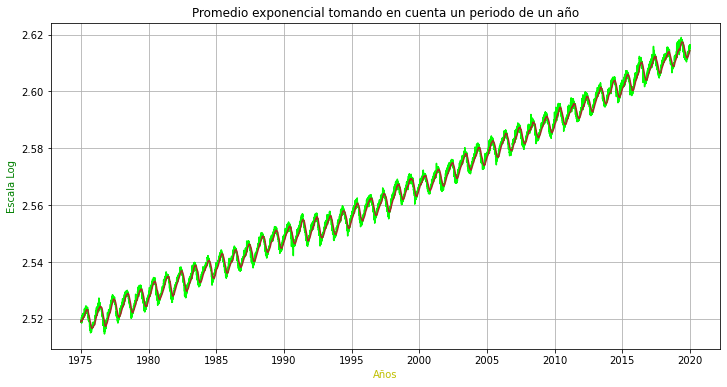

In [21]:

EWM_avg = ts_test_log.ewm(halflife=20).mean()
plt.plot(ts_test_log, color="lime")
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='y')
plt.ylabel('Escala Log',color='g')
plt.title('Promedio exponencial tomando en cuenta un periodo de un año')
plt.grid()
plt.show();

Define un nuevo dataframe con la diferencia entre la serie logaritmo original y el promedio móvil, y prueba después su estacionaridad.

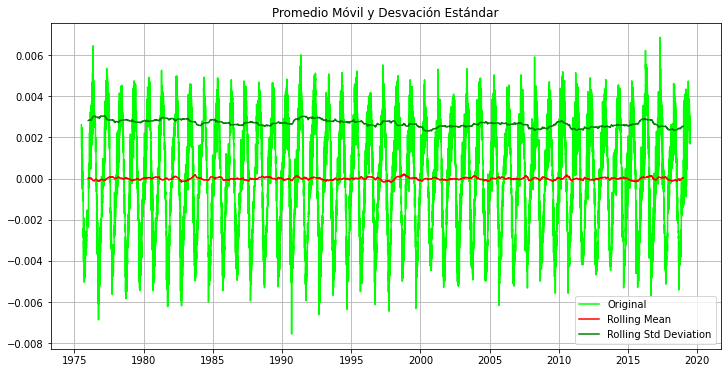

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.519801e+01
p-value                        5.883355e-28
#Lags Used                     4.300000e+01
Number of Observations Used    1.602800e+04
Critical Value (1%)           -3.430758e+00
Critical Value (5%)           -2.861720e+00
Critical Value (10%)          -2.566866e+00
dtype: float64


In [22]:
ts_diff = ts_test_log - moving_avg 
dfp=ts_diff.dropna(inplace=True)

#probamos la estacioaridad 
test_stationarity(ts_diff)

prueba la estacionaridad de esa última serie de tiempo 'ts_test_log_diff'.

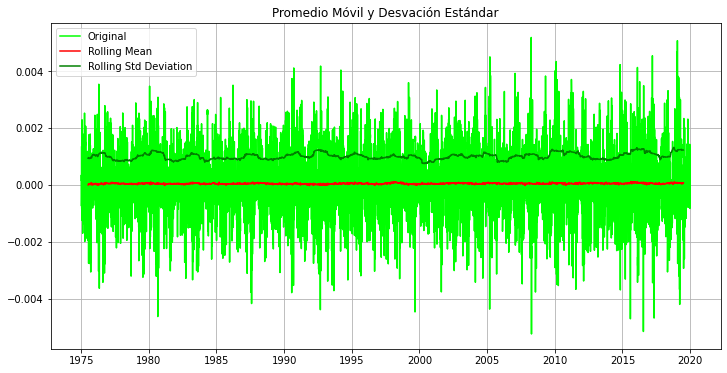

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.037299e+01
p-value                        2.238764e-18
#Lags Used                     4.300000e+01
Number of Observations Used    1.638500e+04
Critical Value (1%)           -3.430749e+00
Critical Value (5%)           -2.861716e+00
Critical Value (10%)          -2.566864e+00
dtype: float64


In [23]:
ts_diff  = ts_test_log - ts_test_log.shift(periods=7)
dfcc=ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

Construye un modelo ARIMA de la serie 'ts_test_log_diff', calculando los parámetros p, q y utiliza d=1 (ya que hemos ya derivado una vez) 

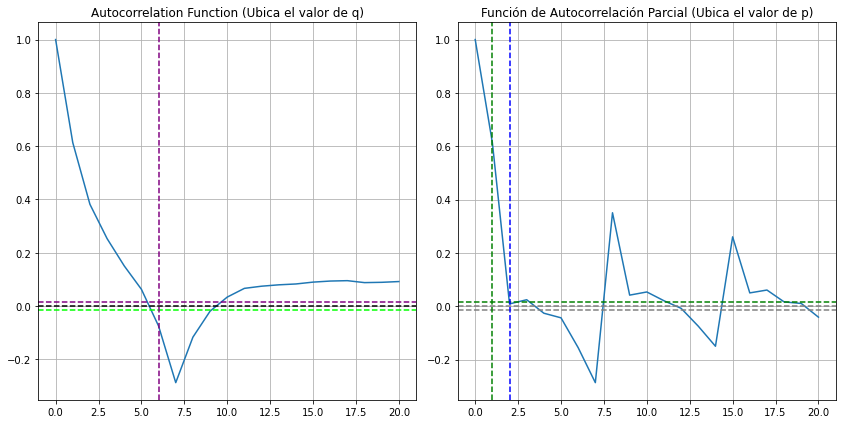

In [24]:
ts_test_log_diff = ts_diff
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='black')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='lime')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='purple')
#Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=6, linestyle='--', color='purple')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=1, linestyle='--', color='green')
plt.axvline(x=2, linestyle='--', color='blue')
plt.grid()
plt.title('Función de Autocorrelación Parcial (Ubica el valor de p)')

plt.tight_layout()

Para seleccionar el mejor modelo, calcula el Criterio de Información de Akaike (AIC) de los modelos: AR(p), MA(q), y ARIMA (p,d,q).

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                16435
Model:                 ARIMA(2, 1, 0)   Log Likelihood               98463.038
Method:                       css-mle   S.D. of innovations              0.001
Date:                Mon, 15 Mar 2021   AIC                        -196918.075
Time:                        02:51:23   BIC                        -196887.247
Sample:                    01-02-1975   HQIC                       -196907.893
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.917e-06    3.3e-06      1.792      0.073   -5.53e-07    1.24e-05
ar.L1.D.value    -0.2436      0.008    -31.784      0.000      -0.259      -0.229
ar.L2.D.value    -0.1864      0.008    -

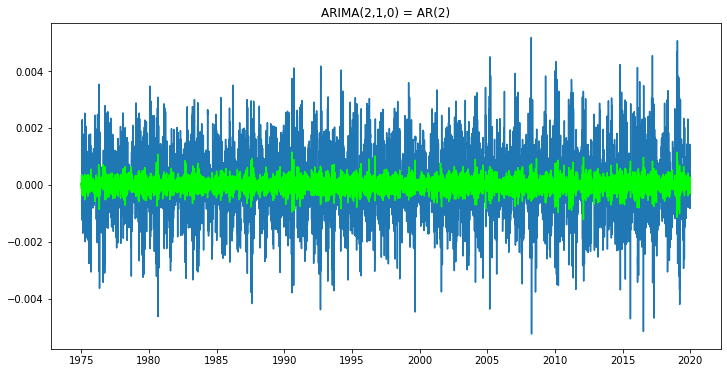

In [25]:
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='lime')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

Modelo MA(q): (p,d,q) = (0,1,4) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                16435
Model:                 ARIMA(0, 1, 4)   Log Likelihood               98818.350
Method:                       css-mle   S.D. of innovations              0.001
Date:                Mon, 15 Mar 2021   AIC                        -197624.699
Time:                        02:52:10   BIC                        -197578.456
Sample:                    01-02-1975   HQIC                       -197609.425
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.891e-06   1.95e-06      3.029      0.002    2.08e-06     9.7e-06
ma.L1.D.value    -0.3029      0.008    -38.751      0.000      -0.318      -0.288
ma.L2.D.value    -0.1772      0.008    -

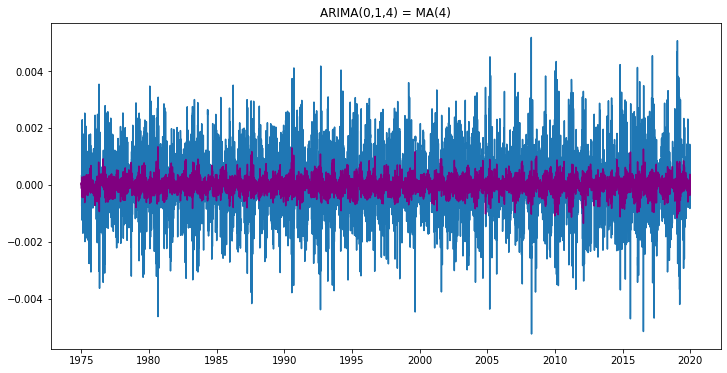

In [26]:
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='purple')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

Modelo ARIMA(p): (p,d,q) = (2,1,4)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                16435
Model:                 ARIMA(2, 1, 4)   Log Likelihood               98820.685
Method:                       css-mle   S.D. of innovations              0.001
Date:                Mon, 15 Mar 2021   AIC                        -197625.369
Time:                        02:57:15   BIC                        -197563.712
Sample:                    01-02-1975   HQIC                       -197605.003
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.889e-06   1.96e-06      2.999      0.003    2.04e-06    9.74e-06
ar.L1.D.value     0.5070      0.772      0.657      0.511      -1.005       2.019
ar.L2.D.value    -0.2750      0.218     

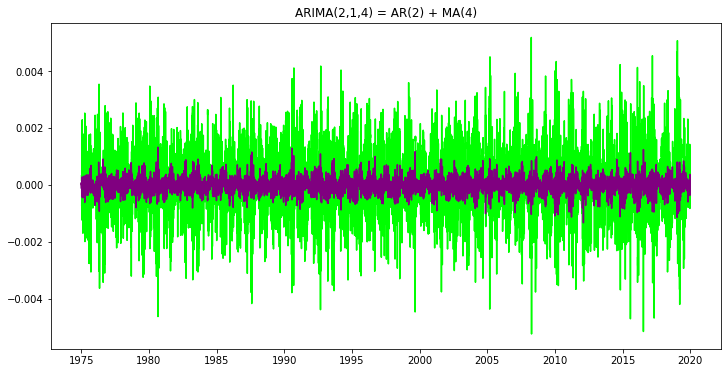

In [30]:
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff, color='lime')
plt.plot(results_ARIMA.fittedvalues, color='purple')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.

In [31]:
prediccion_ARIMA_ = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(prediccion_ARIMA_) 

date
1975-01-02    0.000006
1975-01-03    0.000067
1975-01-04   -0.000092
1975-01-05   -0.000134
1975-01-06   -0.000054
                ...   
2019-12-27   -0.000054
2019-12-28   -0.000194
2019-12-29    0.000031
2019-12-30   -0.000187
2019-12-31   -0.000275
Length: 16435, dtype: float64


In [32]:
prediccion_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
prediccion_ARIMA_log = prediccion_ARIMA_log.add(prediccion_ARIMA_)
print(prediccion_ARIMA_log.head())
print(prediccion_ARIMA_log.tail())

date
1975-01-01         NaN
1975-01-02    2.518743
1975-01-03    2.519435
1975-01-04    2.519435
1975-01-05    2.519248
dtype: float64
date
2019-12-27    2.615738
2019-12-28    2.615061
2019-12-29    2.615960
2019-12-30    2.616078
2019-12-31    2.616127
dtype: float64


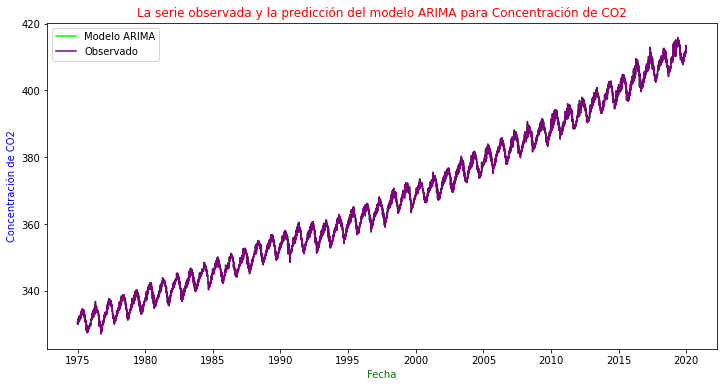

In [35]:
prediccion_ARIMA = 10**(prediccion_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(prediccion_ARIMA, label='Modelo ARIMA',color = "lime");
plt.plot(df2, label='Observado', color = "purple");
plt.xlabel('Fecha', color = "g")
plt.ylabel('Concentración de CO2', color = "b")
plt.title('La serie observada y la predicción del modelo ARIMA para Concentración de CO2', color = "r")
plt.legend(loc='best');

Calcula el error RMSE

In [37]:
RMSE = np.sqrt(np.mean((prediccion_ARIMA - df2)**2))
print('RMSE:', RMSE)


RMSE: 0.18131526122251335


Por último contrasta los 5 últimos años de la Serie de CO2 y el modelo ARIMA para ver mas a detalles el modelo

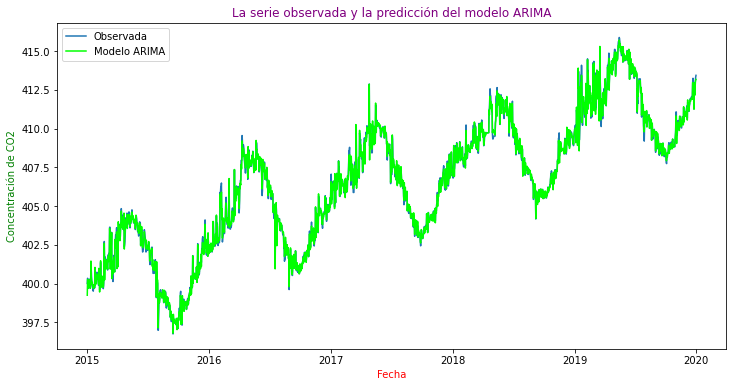

In [40]:
ts_test_last = df2.tail(1825)
prediccion_ARIMA_ = prediccion_ARIMA.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(prediccion_ARIMA_, label='Modelo ARIMA',color="lime");
plt.xlabel('Fecha', color = "r")
plt.ylabel('Concentración de CO2', color = "g")
plt.title('La serie observada y la predicción del modelo ARIMA', color = "purple")
plt.legend(loc='best');